In [16]:
from __future__ import absolute_import, division, print_function

import pathlib

from astropy.io import fits

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation, Conv1D
print(tf.__version__)

from scipy.io import readsav

1.14.0


In [104]:
import matplotlib as m
fig_size = (8,6)
font = 'Helvetica'
params = {'backend': 'tkagg',
          'axes.labelsize': 15,
          'axes.titlesize': 15,
          'font.size': 12,
          'legend.fontsize': 12,
          'font.family': 'sans-serif',
          'font.sans-serif': font,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,
          'text.usetex': True,
          'figure.figsize': fig_size,
          'figure.dpi': 125,
          'lines.linewidth': 1.0,
          'axes.linewidth':1.0,
          'image.interpolation'  : 'nearest',
          'xtick.major.size'     : 5,      # major tick size in points
          'xtick.minor.size'     : 3.5,      # minor tick size in points
          'xtick.major.width'    : 0.5,    # major tick width in points
          'xtick.minor.width'    : 0.3,    # minor tick width in points
          'axes.spines.top': False,
          'axes.spines.right':False,
          'xtick.top': False,
          'ytick.right': False,
          'axes.formatter.useoffset': False
}
m.rcParams.update(params)
m.rcParams['text.latex.preamble'] = [
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
       r'\usepackage{helvet}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
]

m.rcParams['mathtext.fontset'] = 'custom'
m.rcParams['mathtext.rm'] = font
m.rcParams['mathtext.it'] = font+':italic'
m.rcParams['mathtext.bf'] = font+':bold'
m.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]


In [85]:
def load_spectral_profiles(directory,filename):
    hdul     = fits.open(directory+filename)
    spectrum = hdul[0].data
    print(hdul.header)
    return spectrum 

def build_conv_model():
  #build the NN needed for the problem accomodating a single
  #convolutional layer and two densely connected hidden layer
  kSzConv1D = 5
  model = keras.Sequential([
    layers.Conv1D(25, (3,),
        activation='relu',strides=1,input_shape=[waveNumd,1]),
    layers.Conv1D(15, (3,),
        activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(15, (3,),
        activation='relu'),
    layers.Conv1D(25, (3,),
        activation='relu'),
    #layers.MaxPooling1D(2),
    #layers.GlobalAveragePooling1D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    #layers.Dense(30,activation=tf.nn.relu),
    layers.Dense(30,activation=tf.nn.relu),  
    #layers.GlobalAveragePooling1D(),
    #layers.Dense(20, activation='sigmoid'),    
    #layers.Dense(10, activation='sigmoid'),
    layers.Dense(waveNumd-1)])
  optimizer = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9,
          beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
  #optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1,
  #                                          initial_accumulator_value=0.1, epsilon=1e-07)


  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

def load_spectral_profiles(directory,filename):
    hdul     = fits.open(directory+filename)
    spectrum = hdul[0].data
    return spectrum 

def radial_dist(sizeX,sizeY):
    '''Prepare a flat array of the radial distance of the pixel
    from the optical center of the system -- used for removing 
    uncorrected blueshifts
    '''
    
    centerX = sizeX/2
    centerY = sizeY/2
    
    radialDistances = np.zeros((sizeX,sizeY))
    
    for ii in range(sizeX):
        for jj in range(sizeY):
            radialDistances[ii,jj] = (centerX-ii)**2 + (centerY-jj)**2
    
    radialDistances = np.reshape(radialDistances,(sizeX*sizeY))
    
    return radialDistances


def prepare_data(spectrum):
    shape = spectrum.shape
    spec = np.reshape(spectrum,(shape[0],shape[1]*shape[2]))
    spec = np.swapaxes(spec,0,1)
    return spec
    
def plot_spec_profile_comparison(wavescale,profile_FP1,profile_FP2,profile_inferred):
    plt.figure(dpi=250)
    plt.style.use('ggplot')
    plt.plot(wavescale,profile_FP1,'g.--',label='FP1')
    plt.plot(wavescale,profile_FP2,'b.--',label='FP2')
    plt.plot(wavescale,profile_inferred,'k.--',label = 'Inferred')
    plt.legend()
    plt.ylabel('Normalized Intensity')
    plt.xlabel('Wavelength, $\AA$')
    plt.show()
    
def Lorentzian(x0,x,gamma):
    x2  = (x0-x)*(x0-x)
    exp = gamma/(np.pi*(x2+gamma*gamma))
    return exp

def Gaussian(x,mu,sigma):
    return np.exp((-1)*(x-mu)*(x-mu)/(2*sigma*sigma))/np.sqrt(2*np.pi*sigma*sigma)
    
def produce_FP_transmission_peak(dlambda,lambda_0,Nlambda):
    wave_I = np.linspace((lambda_0-dlambda),(lambda_0+dlambda),num=Nlambda)
    ab = readsav('IBIS.FP1.FP2.profiles.6563.8542.sav')
    wave          = np.linspace(-24,24,num=48001)
    t_FP1_6563    = ab['ibis_fp1_profile_6563']
    t_FP2_6563    = ab['ibis_fp2_profile_6563'] 
    #print(wave,wave_I,t_FP1_6563)
    filterProfile = np.interp(wave_I,wave,t_FP2_6563)
    return filterProfile

def convolve(signal,filterProfile):
    return np.convolve(signal,filterProfile)

## Preview of some of the FISS data.

(100, 256, 512)


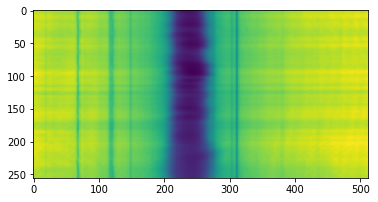

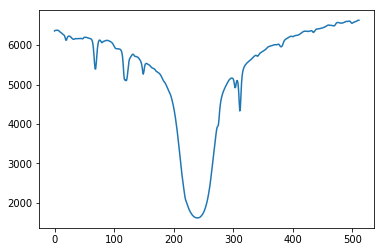

(100, 250, 502)


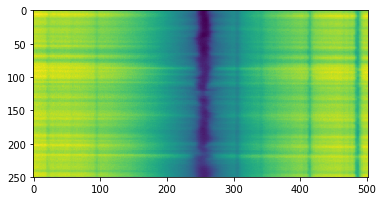

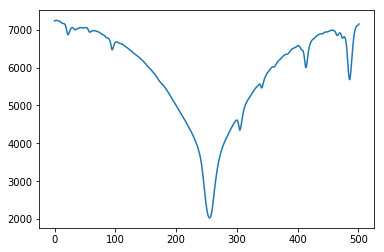

In [46]:
a = load_spectral_profiles('','FISS_20160622_174421_A1.fts')
print(a.shape)
plt.imshow(a[0,:,:])
plt.show()

plt.plot(np.mean(a[:,:,:],axis=(0,1)))
plt.show()

a = load_spectral_profiles('','FISS_20160622_175412_B1.fts')
print(a.shape)
plt.imshow(a[0,:,:])
plt.show()

plt.plot(np.mean(a[:,:,:],axis=(0,1)))

## Convolve the FISS data with some PSFs

AttributeError: Unknown property markerwidth

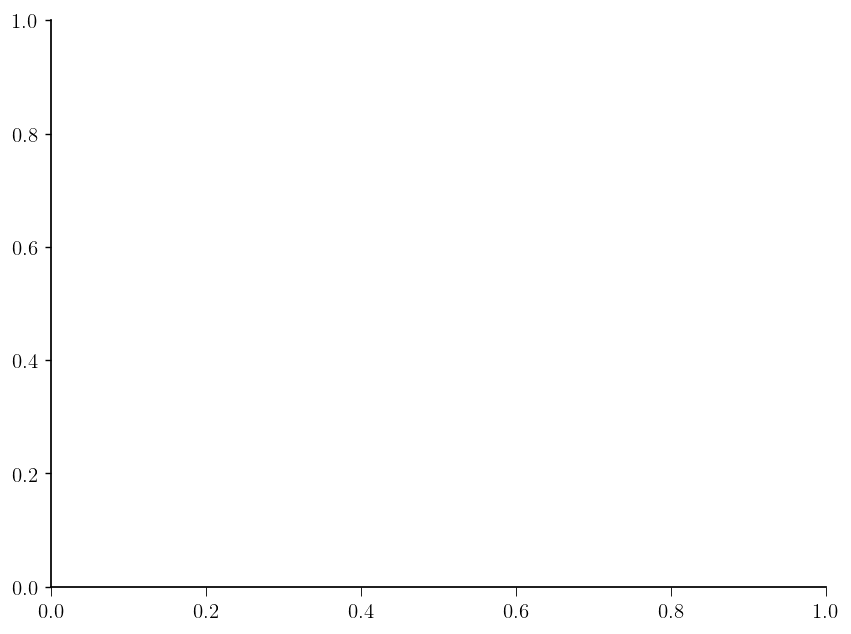

In [106]:
ab = readsav('IBIS.FP1.FP2.profiles.6563.8542.sav')
wave = np.linspace(-24,24,num=48001)
plt.figure(figsize=(8,6))
plt.plot(wave,ab['ibis_fp2_profile_6563'],'r.--',label='FP2 only',markerwidth=5)
plt.plot(wave,ab['ibis_fp1_profile_6563'],'b.--',label='FP1 only')
plt.plot(wave,ab['ibis_fp1_profile_6563']*ab['ibis_fp2_profile_6563'],'g.--',label='IBIS transmission profile')
plt.legend()
plt.yscale('log')
plt.ylabel('Transmissivity')
plt.ylim(5e-7,15)
plt.xlabel('Wavelength,$\\AA$')
plt.xlim(-4.864,4.864)
plt.show()

### Make some ML magic

In [ ]:
trans_filter = produce_FP_transmission_peak(4,0,502)
#trans_filter[0:130] = 0
#trans_filter[370:] = 0 
plt.plot(trans_filter)
plt.grid()
plt.yscale('log')
plt.show()
plt.figure(dpi=200)
b = np.convolve(a[0,0,:],trans_filter,mode='same')
print("Shape of b is %d"%b.shape)
print("Shape of a[0,0,:] is %d"%a[0,0,:].shape)
plt.plot((a[0,0,:]-np.amin(a[0,0,:]))/(np.amax(a[0,0,:])-np.amin(a[0,0,:])),'r.--',label='Genuine')
plt.plot((b-np.amin(b))/(np.amax(b)-np.amin(b)),'g.--',label='Convolved')
plt.legend()
plt.grid()
plt.show()